In [1]:
import os
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob

In [3]:
visdrone_categories = ['bg','pedestrian', 'person', 'car', 'van', 'bus', 'truck', 'motor', 'bicycle', 'awning-tricycle', 'tricycle','empty_0','empty_1']
WATER_CLASSES = visdrone_categories
num_classes = 80#len(WATER_CLASSES)
l1 = 1e-8
activation = 'selu'

In [4]:
path_visDrone = '/home/mvlab/Downloads/dataset/VisDrone2019/VisDrone2019-DET-train/'
path_visDrone_annotation = path_visDrone + 'annotations/'
path_visDrone_image = path_visDrone + 'images/'
os.path.isdir(path_visDrone_annotation), os.path.isdir(path_visDrone_image)


(True, True)

In [5]:
def load_visdrone_data(path_visDrone, human_only=True):
    
    list_image_arr = []
    list_cbbox = []
    path_visDrone_annotation = path_visDrone + 'annotations/'
    path_visDrone_image = path_visDrone + 'images/'
    os.path.isdir(path_visDrone_annotation), os.path.isdir(path_visDrone_image)
    list_annotation = glob(path_visDrone_annotation+'*.*')
    list_image_path = glob(path_visDrone_image+'*.*')
    len(list_annotation), len(list_image_path), list_annotation[0]
    
    for i in range(len(list_annotation)):
        path_annotation = list_annotation[i]
        
        df = pd.read_csv(path_annotation, header=None)
        
        bbox_xywh = np.array(df.iloc[:, :4])
        cls = np.array(df.iloc[:, 5])
        x0 = bbox_xywh[:, 0]
        y0 = bbox_xywh[:, 1]
        w = bbox_xywh[:, 2]
        h = bbox_xywh[:, 3]
        x1 = x0 + w
        y1 = y0 + h
        
        file_name_annotation = path_annotation.split('/')[-1].split('.')[0]
        file_name_image = path_visDrone_image+file_name_annotation+'.jpg'
        img = Image.open(file_name_image)
        img_arr = np.array(img)
        img_h, img_w, img_c = img_arr.shape
        cbbox_norm = np.stack((cls, y0/img_h, x0/img_w, y1/img_h, x1/img_w), axis=1)
        
        if human_only:
            
            human_mask = np.logical_and(cls > 0, cls < 3)
            vehicle_mask = cls > 2
            is_human_contain = np.any(human_mask)
            human_count = np.count_nonzero(human_mask)
            if not is_human_contain or human_count < 30:#30:154, 40:88                
                continue
            
            cls = np.where(human_mask, 1.0, cls)
            cls = np.where(vehicle_mask, 3.0, cls)
            cbbox_norm = np.stack((cls, y0/img_h, x0/img_w, y1/img_h, x1/img_w), axis=1)
            #cbbox_norm = cbbox_norm[human_mask]               
            #cbbox_norm[:, 0] = 1

        list_image_arr.append(img_arr)
        list_cbbox.append(cbbox_norm)
        if len(list_image_arr)>10:
            break
        if i%100==0:
            print(len(list_annotation), i, file_name_annotation, img_arr.shape)
    return list_image_arr, list_cbbox

In [6]:
list_visdrone_image_arr, list_visdrone_cbbox = load_visdrone_data(path_visDrone)
print(len(list_visdrone_image_arr))

11


(array([ 25.,   0.,   0., 660.,   0.,   0.,   0.,   0.,   0., 629.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

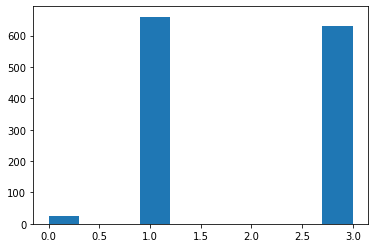

In [7]:
visdrone_cbbox = np.concatenate(list_visdrone_cbbox, 0)
visdrone_cbbox.shape
plt.hist(visdrone_cbbox[:, 0])

In [8]:
input_list_all = list_visdrone_image_arr
bbox_list_all = list_visdrone_cbbox
print('extend', len(list_visdrone_image_arr), len(input_list_all), len(bbox_list_all))

extend 11 11 11


In [9]:
colors = np.random.rand(num_classes, 3)
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12),
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    img_h, img_w, img_c = image.shape
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 3] - boxes[:, 1]
    boxes_height = boxes[:, 2] - boxes[:, 0]
    box_min_width = np.min(boxes_width)
    box_mean_width = np.mean(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:min:%d mean:%d max:%d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_mean_width, box_max_width))
    plt.title(title)
    
    for box, cls in zip(boxes, classes):
        y1, x1, y2, x2 = box        
        w, h = x2 - x1, y2 - y1
        cls = int(cls)
        color = colors[cls]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=1
        )
        ax.add_patch(patch)
        ax.text(
            x1, y1, str(cls), bbox={"facecolor": color, "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,
        )
    plt.show()
    return ax

In [15]:
def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = input_list_all[i]
            sample_box = bbox_list_all[i]
            label = sample_box[:, 0]
            bbox = sample_box[:, 1:]

            h, w, c = img_arr.shape
            #if w<2000: continue
            scale = np.array((h, w, h, w), dtype=np.float)
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale
            #print('bbox_norm', bbox, bbox_norm)
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

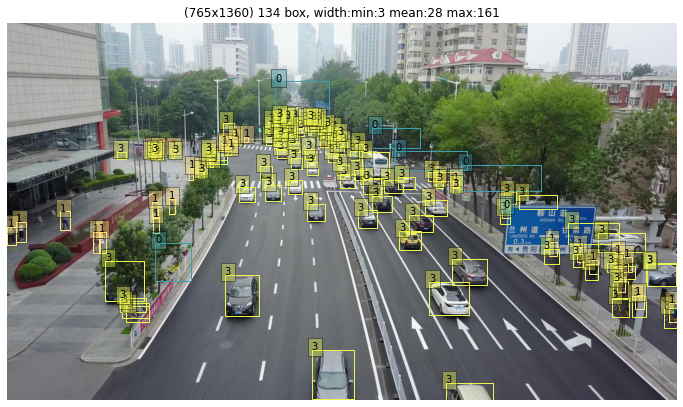

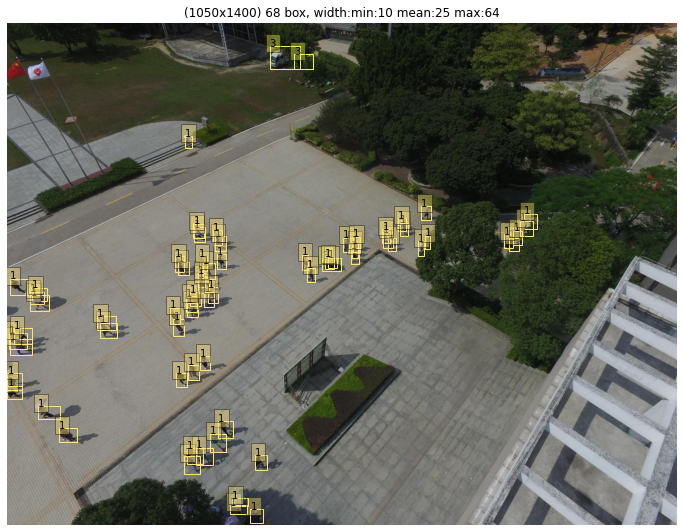

In [16]:
display_data(input_list_all, bbox_list_all, 10)